# <div style='background:#8db8f7;border-radius:42px 42px;padding:40px;text-align: center;font-size: 32px;'>Children or Adults?</div>

# <h2><span style="color:#8db8f7;">Imports libraries</span><h2> 

In [1]:
import numpy as np
import time
from sklearn.model_selection import train_test_split
from tqdm.autonotebook import tqdm, trange

import seaborn as sns
import matplotlib.pyplot as plt

import torch
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn


BATCH_SIZE = 32

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  after removing the cwd from sys.path.


# <h2><span style="color:#8db8f7;">Define dataloaders and transforms</span><h2> 

In [2]:
transform = transforms.Compose([
    transforms.Resize((int(300), int(300))),
    transforms.ToTensor()
])

data = datasets.ImageFolder(
    root='../input/children-vs-adults-images/train',
    transform=transform
)

train_idx, valid_idx = train_test_split(list(range(len(data))), train_size=0.9)

dataset = {
    'train': torch.utils.data.Subset(data, train_idx),
    'val': torch.utils.data.Subset(data, valid_idx)
}

dataloader = {
    'train': torch.utils.data.DataLoader(
        dataset=dataset['train'], batch_size=BATCH_SIZE, shuffle=True, num_workers=4
    ),
    'val': torch.utils.data.DataLoader(
        dataset=dataset['val'], batch_size=BATCH_SIZE, shuffle=False, num_workers=4
    ),
}

transform = transforms.Compose([
    transforms.Resize((int(300), int(300))),
    transforms.ToTensor()
])

dataset_test = datasets.ImageFolder(
    root="../input/children-vs-adults-images/test",
    transform=transform
)

dataloader_test = torch.utils.data.DataLoader(dataset_test, shuffle=False, batch_size=BATCH_SIZE)

datasets_sizes = {x: len(dataset[x]) for x in ['train', 'val']}
class_names = np.array(data.classes)



/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


#  <h2><span style="color:#8db8f7;">Define train and inference functions</span><h2> 

In [3]:
def train_model(model, criterion, optimizer, scheduler, epochs=25):
    '''

    main training code

    '''
    start = time.time()
    
    use_gpu = torch.cuda.is_available()
  
    best_mode_wts = model.state_dict()
    best_accuracy = 0.0

    losses = {'train': [], 'val': []}
    accuracy = {'train': [], 'val': []}

    pbar = trange(epochs, desc='Epoch')

    for epoch in pbar:

        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train(True)
            else:
                model.eval()

            curr_loss = 0.0
            curr_corrects = 0  

            for data in tqdm(dataloader[phase], leave=False, desc=f'{phase} iter'):
                inputs, labels = data
                if use_gpu:
                    inputs, labels = inputs.cuda(), labels.cuda()
                else:
                    inputs, labels = inputs, labels
        
                if phase == 'train':
                    optimizer.zero_grad()

                if phase == 'val':
                    with torch.no_grad():
                        outputs = model(inputs)
                else:
                    outputs = model(inputs)

                preds = torch.argmax(outputs, -1)
                loss = criterion(outputs, labels)

                if phase == 'train':
                    loss.backward()
                    optimizer.step()

                curr_loss += loss.item()
                curr_corrects += int(torch.sum(preds == labels.data))

            epoch_loss = curr_loss / datasets_sizes[phase]
            epoch_accuracy = curr_corrects / datasets_sizes[phase]

            losses[phase].append(epoch_loss)
            accuracy[phase].append(epoch_accuracy)

            pbar.set_description('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_accuracy))

            if phase == 'val' and epoch_accuracy > best_accuracy:
                best_accuracy = epoch_accuracy
                best_model_wts = model.state_dict()
  
    time_elapsed = time.time() - start
    
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60
    ))
    print('Best val Acc: {:.4f}'.format(best_accuracy))

    model.load_state_dict(best_model_wts)
    
    return model, losses, accuracy

def evaluate(model):
    '''

    count accuracy on a test set

    '''

    model.eval()

    curr_correct = 0
    for data in dataloader['val']:
        inputs, labels = data

    if torch.cuda.is_available():
        inputs, labels = inputs.cuda(), labels.cuda()

    output = model(inputs)
    _, preds = torch.max(output, 1)

    curr_correct += int(torch.sum(preds == labels))

    return curr_correct / datasets_sizes['val']

def predict(model, dataloader_test, class_names):
    probs = []
    model.eval()
    with torch.no_grad():
        
        for inputs, y in tqdm(dataloader_test):
            if torch.cuda.is_available():
                inputs = inputs.cuda()
                
            preds = model(inputs).cpu()
            probs.append(preds)
            
    print(f'probs shape before softmax: {len(probs)}')
    probs = nn.functional.softmax(torch.cat(probs), dim=-1).numpy()
    print(f'probs shape after softmax: {probs.shape}')
    probs = np.argmax(probs, axis=1)
    probs = class_names[probs]
    return probs

In [4]:
model_efficientnet = models.efficientnet_b3(pretrained=True)

for param in model_efficientnet.parameters():
    param.require_grad = False

model_efficientnet.classifier    
model_efficientnet.classifier = nn.Sequential(nn.Dropout(p=0.3),
                                              nn.Linear(1536, len(data.classes))
                                             )

model_efficientnet = model_efficientnet.cuda()

Downloading: "https://download.pytorch.org/models/efficientnet_b3_rwightman-cf984f9c.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b3_rwightman-cf984f9c.pth


  0%|          | 0.00/47.2M [00:00<?, ?B/s]

#  <h2><span style="color:#8db8f7;">Train model</span><h2> 

In [5]:
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(list(model_efficientnet.parameters()), lr=1e-4)
exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=4, gamma=0.1)

model_efficientnet, losses_efficientnet, accs_efficientnet = train_model(model_efficientnet, loss_func, optimizer, exp_lr_scheduler, epochs=12)

Epoch:   0%|          | 0/12 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


train iter:   0%|          | 0/20 [00:00<?, ?it/s]

val iter:   0%|          | 0/3 [00:00<?, ?it/s]

train iter:   0%|          | 0/20 [00:00<?, ?it/s]

val iter:   0%|          | 0/3 [00:00<?, ?it/s]

train iter:   0%|          | 0/20 [00:00<?, ?it/s]

val iter:   0%|          | 0/3 [00:00<?, ?it/s]

train iter:   0%|          | 0/20 [00:00<?, ?it/s]

val iter:   0%|          | 0/3 [00:00<?, ?it/s]

train iter:   0%|          | 0/20 [00:00<?, ?it/s]

val iter:   0%|          | 0/3 [00:00<?, ?it/s]

train iter:   0%|          | 0/20 [00:00<?, ?it/s]

val iter:   0%|          | 0/3 [00:00<?, ?it/s]

train iter:   0%|          | 0/20 [00:00<?, ?it/s]

val iter:   0%|          | 0/3 [00:00<?, ?it/s]

train iter:   0%|          | 0/20 [00:00<?, ?it/s]

val iter:   0%|          | 0/3 [00:00<?, ?it/s]

train iter:   0%|          | 0/20 [00:00<?, ?it/s]

val iter:   0%|          | 0/3 [00:00<?, ?it/s]

train iter:   0%|          | 0/20 [00:00<?, ?it/s]

val iter:   0%|          | 0/3 [00:00<?, ?it/s]

train iter:   0%|          | 0/20 [00:00<?, ?it/s]

val iter:   0%|          | 0/3 [00:00<?, ?it/s]

train iter:   0%|          | 0/20 [00:00<?, ?it/s]

val iter:   0%|          | 0/3 [00:00<?, ?it/s]

Training complete in 2m 15s
Best val Acc: 0.9118


#  <h2><span style="color:#8db8f7;">Analysis</span><h2> 

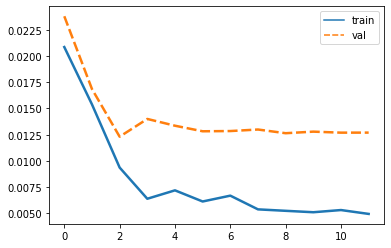

In [6]:
sns.lineplot(data=losses_efficientnet, palette="tab10", linewidth=2.5)
plt.show()

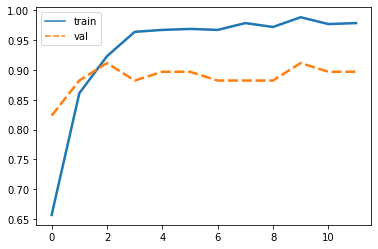

In [7]:
sns.lineplot(data=accs_efficientnet, palette="tab10", linewidth=2.5)
plt.show()

In [8]:
import pickle

with open('model_efficientnet_b3.pickle', 'wb') as f:
    pickle.dump(model_efficientnet, f)